# lesson 07: CNNs

This lesson is based on Walter de Back's [2-convolution.ipynb](https://gitlab.com/wdeback/dl-keras-tutorial/-/blob/master/notebooks/2-convolution.ipynb) and [3-cnn-mnist.ipynb](https://gitlab.com/wdeback/dl-keras-tutorial/-/blob/master/notebooks/3-cnn-mnist.ipynb).


## Ingredients of convolutional filters

The basic ingredients of convolutional neural networks (CNNs) are:

1. **convolution** filters
2. non-linear **activation**
3. **pooling** operation

We'll leave the non-linear activation for the next session on neural nets. 

Here, we'll focus on the image processing operations: convolution and pooling. 


In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import scipy as sp 

from scipy.ndimage.filters import convolve
from skimage import data

plt.rcParams['image.cmap'] = 'viridis'
plt.style.use('dark_background')

## What is convolution?

- Convolution is the application of a filter over an image. 
- convolution transforms the input image into a different image
- this output image is called a feature map

![](http://i.stack.imgur.com/GvsBA.jpg)


To illustrate what convolution is, let's

1. get an input image and
2. define some handcrafted convolution filters

and apply these filters on the input image.

(-0.5, 383.5, 302.5, -0.5)

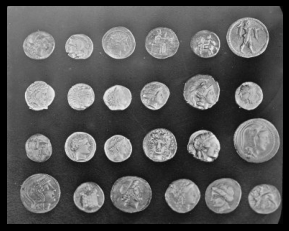

In [2]:
# feel free to experiment with different input images
# that are provided by scikit-image

#im = data.checkerboard()
#im = data.astronaut()
#im = data.rocket()
im = data.coins()

if im.ndim == 3:
    im = np.mean(im, axis=2)
im = np.asarray(im, dtype=np.float32)
plt.imshow(im, cmap='gray')
plt.axis('off')

**(Handcrafted) convolution filters**

In [3]:
cross =  [[-1,1,-1],
          [1,1,1],
          [-1,1,-1]]

sobel1 = [[1,0,-1],
          [2,0,-2],
          [1,0,-1]]

sobel2 = np.array(sobel1).T

emboss = [[-1,-1, 0],
          [-1, 0, 1],
          [ 0, 1, 1]]

sharpen =[[-1,-1,-1],
          [-1, 9,-1],
          [-1,-1,-1]]

sharpen =[[ 1, 1, 1],
          [ 1, -7, 1],
          [ 1, 1, 1]]

mean    =[[ 1, 1, 1],
          [ 1, 1, 1],
          [ 1, 1, 1]]


In [4]:
im1 = convolve(im, cross)
im2 = convolve(im, sobel2)
im3 = convolve(im, sobel1)
im4 = convolve(im, emboss)
im5 = convolve(im, sharpen)
im6 = convolve(im, mean)

In [5]:
def plot_kernel(kernel, ax, label):
    ax.imshow(kernel)
    for (j,i),text in np.ndenumerate(kernel):
        ax.text(i,j,int(text),ha='center',va='center',fontsize=14, color='w')
        ax.text(i,j,int(text),ha='center',va='center',fontsize=14, color='w')
    ax.set_title(label)
    ax.axis('off')
    
def plot_feature_map(image, ax, label):
    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

Show the convolution filter and the image after application of the filter.

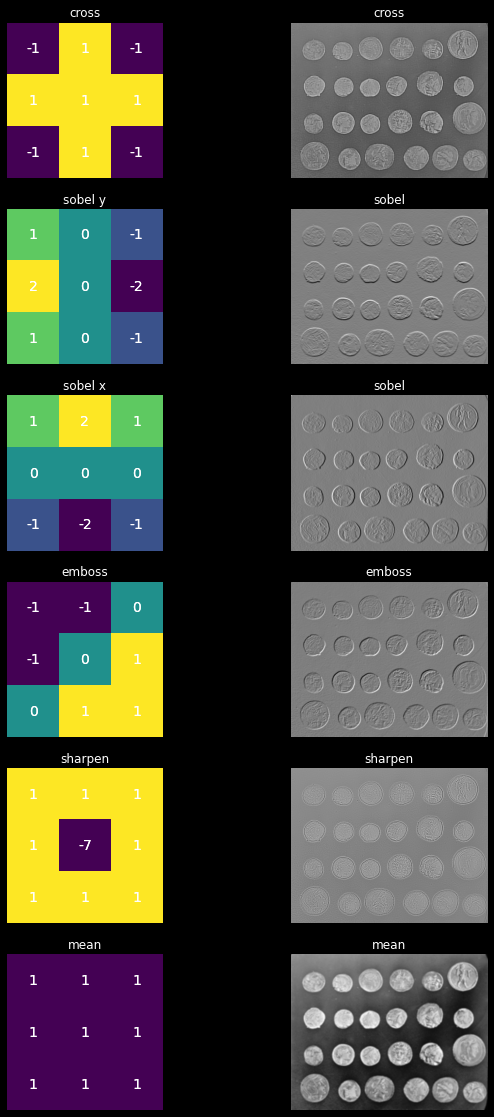

In [6]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(10,20))#, sharex=True, sharey=True)

plot_kernel(cross,   ax[0,0], 'cross')
plot_kernel(sobel2,  ax[2,0], 'sobel x') #published in 1968, see https://en.wikipedia.org/wiki/Sobel_operator
plot_kernel(sobel1,  ax[1,0], 'sobel y') #published in 1968, see https://en.wikipedia.org/wiki/Sobel_operator
plot_kernel(emboss,  ax[3,0], 'emboss')
plot_kernel(sharpen, ax[4,0], 'sharpen')
plot_kernel(mean,    ax[5,0], 'mean')

plot_feature_map(im1, ax[0,1], 'cross')
plot_feature_map(im2, ax[1,1], 'sobel')
plot_feature_map(im3, ax[2,1], 'sobel')
plot_feature_map(im4, ax[3,1], 'emboss')
plot_feature_map(im5, ax[4,1], 'sharpen')
plot_feature_map(im6, ax[5,1], 'mean')

## Random filters
- As you can see, convolution filters are useful to extract features from images, e.g. Sobel filters can detect edges. 

- however, we often do not know in advance what features we'd like to extract. 

- Instead, we'd like to **learn** to extract useful features according to a number of examples, using convolutional neural networks (CNNs). 


- In CNNs, instead of handcrafted convolution filters (aka kernels), we **learn** the values (aka kernel weights) of the filters to detect particular features. 

- Before learning, the kernels are typically set to random values.

- below, we generate 25 random kernels and show their resulting feature maps. This is identical to what the first layer in an unlearned convnet with 25 `3x3` kernels does.

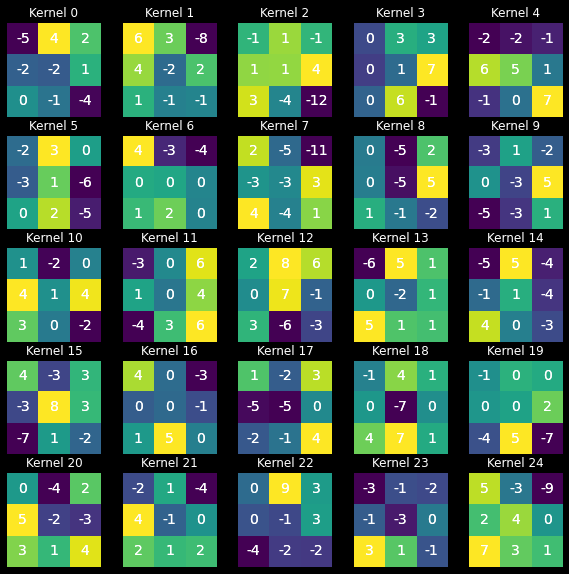

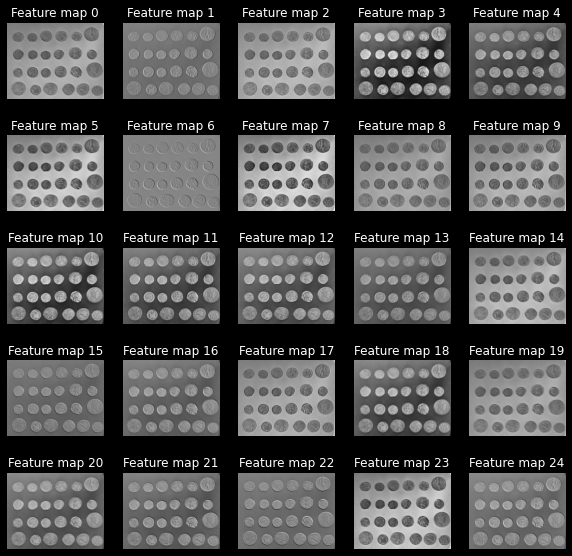

In [7]:
n = 25
nr = int(np.ceil(np.sqrt(n)))
fig1, ax1 = plt.subplots(nrows=nr, ncols=nr, figsize=(10,10), sharex=True, sharey=True)
ax1 = ax1.flatten()
fig2, ax2 = plt.subplots(nrows=nr, ncols=nr, figsize=(10,10), sharex=True, sharey=True)
ax2 = ax2.flatten()


for i in range(n):
    rand_kernel = np.random.normal(loc=0.0, scale=4.0, size=[3,3])
    plot_kernel(rand_kernel, ax1[i], 'Kernel {}'.format(i))

    image = convolve(im, rand_kernel)
    plot_feature_map(image, ax2[i],'Feature map {}'.format(i))
    
    # store images as feature maps
    try:
        feature_maps = np.dstack([feature_maps, image])
    except:
        feature_maps = image


## Pooling

- If we forget about the activation layer for the moment, another common layer type are pooling layers, typically `MaxPooling`. 

- Pooling downsamples the feature maps by taking the local mean `AveragePooling` or maximum `MaxPooling` of each feature map. 

- For purpose of illustration, we take the maximum of each 8x8 block (in CNNs, 2x2 pooling is most often used).

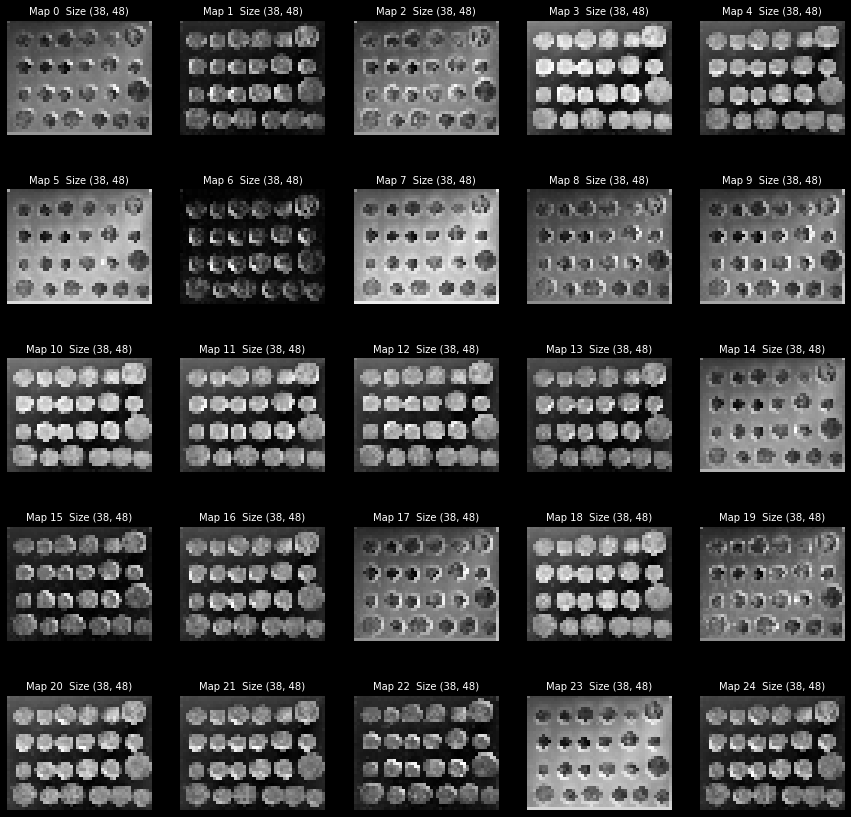

In [8]:
# size of pool blocks
pool_size = (8,8)

def pooling(image, size=(2,2), mode='max'):
    from skimage.measure import block_reduce
    if mode == 'mean':
        return block_reduce(image, block_size=size, func=np.mean)
    else: #mode == 'max':
        return block_reduce(image, block_size=size, func=np.max)

fig, ax = plt.subplots(nrows=nr, ncols=nr, figsize=(15,15), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(n):
    pooled = pooling(feature_maps[:,:,i], pool_size)
    ax[i].imshow(pooled, cmap='gray')
    ax[i].set_title('Map {}  Size {}'.format(i, pooled.shape), fontsize=10)
    ax[i].axis('off')


# Take-Aways

- image convolutions have been known for a long time and existed with fixed kernel weights
  - they act to emphasize certain aspects of images (sharpen edges, remove background, smooth edges)
  - given an arbitrary image analysis task, selecting the correct kernels is tedious
  - in CNNs, this process of selecting the kernels is automated
  
- pooling is the process of downscaling images and only keeping the most important pixels
  - there are using the maximum or average of a gixed neighborhood is mostly done  

# Training a convolution neural network to classify handwritten numbers

Trains a simple convnet on the MNIST dataset.

In [9]:
# %matplotlib inline
# import matplotlib.pylab as plt
# plt.style.use('dark_background')
# import numpy as np


Import modules from keras. 

As before, we will use a model with a `Dense` layer. Additionally, however, we are going to use the 2D convolutional layers `Conv2D` and `MaxPooling2D`.

We will use the mnist dataset.

In [10]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.utils import to_categorical

## Preparing the data

__Loading the image data__

The image data will be imported as tensors of shape: NUM x WIDTH x HEIGHT.

The labels will be imported as tensors of shape: NUM x 1


In [11]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("full dataset")
print(x_train.shape)
print(y_train.shape)

num_classes = 10

# to save time, we will only use the first 15% of the data
fraction = 0.15
cut = int(x_train.shape[0]*fraction)
x_train = x_train[:cut]
y_train = y_train[:cut]
cut = int(x_test.shape[0]*fraction)
x_test = x_test[:cut]
y_test = y_test[:cut]

# input image dimensions
img_rows, img_cols = x_train.shape[1:]
print('img_rows = {}, img_cols = {}'.format(img_rows, img_cols))
print('retaining {} training and {} test images'.format(x_train.shape[0], x_test.shape[0]))

full dataset
(60000, 28, 28)
(60000,)
img_rows = 28, img_cols = 28
retaining 9000 training and 1500 test images


Plot some samples from the image data set with titles showing the ground truth labels


5


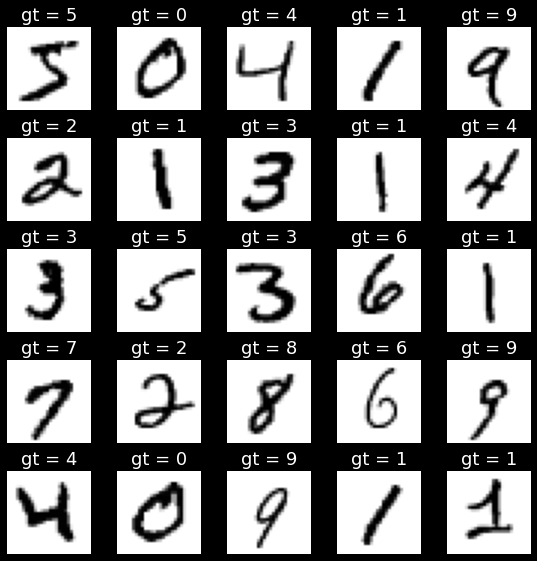

In [12]:
def plot_images(images, labels, gt=None):
    # reduce empty dimensions, if any
    images = np.squeeze(images)
    labels = np.squeeze(labels)
    numrows=int(np.ceil(np.sqrt(images.shape[0])))
    print(numrows)
    fig, axes = plt.subplots(nrows=numrows, ncols=numrows, figsize=(8,8), sharex=True, sharey=True)
    fig.tight_layout()
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=plt.get_cmap('gray_r'))
        ax.set_title('gt = {}'.format(labels[i]), fontsize=18)
        ax.axis('off')
        
        # highlight wrong predictions is gt (ground truth) is provided
        if gt is not None:
            if gt[i] != labels[i]:
                ax.imshow(images[i], cmap=plt.get_cmap('viridis'))
                ax.set_title('{}≠{}'.format(labels[i], gt[i]), fontsize=18, fontdict={'color':'red'})

plot_images(x_train[:25], y_train[:25])

We must be careful about the format in which we should provide our data to the network.

If you use Tensorflow as a backend (as we are doing here), the image data should be provided in a format with the channels (e.g. RGB) as last dimension:

_NUM x WIDTH x HEIGHT x CHANNELS_ (NWHC)

Pytorch currently also uses this convention. Beware of alternative frameworks which use other conventions to represent images.



In [13]:
#Although we are dealing with grayscale image data and only have a single channel,
#we still need to add a dimension for the channels to obtain a 4D input tensor.
X_train = np.expand_dims(x_train, 3)
X_test = np.expand_dims(x_test, 3)
print('New shape: {}'.format(X_train.shape))

New shape: (9000, 28, 28, 1)


__Preprocessing__

We will convert from uint8 to float encoding and scale the values in our image to lie between 0 and 1.
This is typically done across the ML community as some activation functions expose problems when ingesting too small (vanishing gradients) or too high weights (exploding gradients).

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.
X_test /= 255.

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples',X_train.mean())
print(X_test.shape[0], 'test samples',X_test.mean())

x_train shape: (9000, 28, 28, 1)
9000 train samples 0.13141398
1500 test samples 0.12173627


__One-hot encoding__

We need to convert the labels using the one-hot encoding scheme

In [15]:
# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

# Define a convolutional neural network


In [16]:
## Convolutional part

# conv layer with 32 3x3 filters and retified linear activation units
# Note: first layer requires the specification of an input shape
conv1 = Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:])
# conv layer with 64 3x3 filters and retified linear activation units
conv2 = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu')
# max pooling with size 2x2
mpool = MaxPooling2D(pool_size=(2, 2))

# dropout layer
# model.add(Dropout(0.25))

## Multilayer perceptron (MLP) part

# first, we need to flatten the output of the conv to obtain a vector
flat = Flatten()

# add a dense NN layer (= fully connected layer of neurons) with ReLU activation
dense1 = Dense(128, activation='relu')

# Exercise: this is a dropout layer
# dropout = Dropout(0.5)

# final layer is equal to the number of classes and uses SoftMax activation
dense2 = Dense(num_classes, activation='softmax')



In [18]:
#let's build up the computational graph
x_inputs = Input(shape=X_train.shape[1:])

## conv layers
x = conv1(x_inputs)
x = conv2(x)
x = mpool(x)

## mlp layers
x = flat(x)
x = dense1(x)
#x = dropout(x)
output_yhat = dense2(x)

model = keras.Model(inputs = x_inputs, outputs = output_yhat, name="hello-world-cnn")

__Compile the network__

To compile the network, we need to choose a loss function and an optimizer. 

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "hello-world-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dense_1 (Dense)              (None, 10)            

# Train the neural network

In [20]:
batch_size = 128
epochs = 12

In [21]:

history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test, Y_test))

Epoch 1/12


 1/71 [..............................] - ETA: 0s - loss: 2.3073 - accuracy: 0.1719

 2/71 [..............................] - ETA: 2s - loss: 2.2906 - accuracy: 0.2070

 3/71 [>.............................] - ETA: 3s - loss: 2.2804 - accuracy: 0.2083

 5/71 [=>............................] - ETA: 2s - loss: 2.2410 - accuracy: 0.2484

 6/71 [=>............................] - ETA: 3s - loss: 2.2199 - accuracy: 0.2826

 7/71 [=>............................] - ETA: 3s - loss: 2.1963 - accuracy: 0.3326

 9/71 [==>...........................] - ETA: 3s - loss: 2.1453 - accuracy: 0.4071

10/71 [===>..........................] - ETA: 3s - loss: 2.1188 - accuracy: 0.4375

11/71 [===>..........................] - ETA: 3s - loss: 2.0874 - accuracy: 0.4638

12/71 [====>.........................] - ETA: 3s - loss: 2.0588 - accuracy: 0.4798

13/71 [====>.........................] - ETA: 3s - loss: 2.0268 - accuracy: 0.4916

14/71 [====>.........................] - ETA: 3s - loss: 1.9923 - accuracy: 0.5050

15/71 [=====>........................] - ETA: 3s - loss: 1.9522 - accuracy: 0.5203

16/71 [=====>........................] - ETA: 3s - loss: 1.9153 - accuracy: 0.5317

17/71 [======>.......................] - ETA: 3s - loss: 1.8787 - accuracy: 0.5427

18/71 [======>.......................] - ETA: 3s - loss: 1.8429 - accuracy: 0.5499

19/71 [=======>......................] - ETA: 3s - loss: 1.8052 - accuracy: 0.5617

20/71 [=======>......................] - ETA: 3s - loss: 1.7681 - accuracy: 0.5684

22/71 [========>.....................] - ETA: 3s - loss: 1.6898 - accuracy: 0.5863

23/71 [========>.....................] - ETA: 3s - loss: 1.6491 - accuracy: 0.5954

24/71 [=========>....................] - ETA: 3s - loss: 1.6166 - accuracy: 0.6012

25/71 [=========>....................] - ETA: 3s - loss: 1.5857 - accuracy: 0.6081

26/71 [=========>....................] - ETA: 3s - loss: 1.5595 - accuracy: 0.6109

27/71 [==========>...................] - ETA: 2s - loss: 1.5336 - accuracy: 0.6175

28/71 [==========>...................] - ETA: 2s - loss: 1.4990 - accuracy: 0.6247

29/71 [===========>..................] - ETA: 2s - loss: 1.4725 - accuracy: 0.6298

30/71 [===========>..................] - ETA: 2s - loss: 1.4403 - accuracy: 0.6378

31/71 [============>.................] - ETA: 2s - loss: 1.4157 - accuracy: 0.6429

32/71 [============>.................] - ETA: 2s - loss: 1.3902 - accuracy: 0.6482

33/71 [============>.................] - ETA: 2s - loss: 1.3681 - accuracy: 0.6522

34/71 [=============>................] - ETA: 2s - loss: 1.3506 - accuracy: 0.6558

35/71 [=============>................] - ETA: 2s - loss: 1.3356 - accuracy: 0.6571

36/71 [==============>...............] - ETA: 2s - loss: 1.3214 - accuracy: 0.6608

38/71 [===============>..............] - ETA: 2s - loss: 1.2872 - accuracy: 0.6682

39/71 [===============>..............] - ETA: 2s - loss: 1.2691 - accuracy: 0.6725

40/71 [===============>..............] - ETA: 2s - loss: 1.2454 - accuracy: 0.6783

42/71 [================>.............] - ETA: 1s - loss: 1.2127 - accuracy: 0.6855

44/71 [=================>............] - ETA: 1s - loss: 1.1745 - accuracy: 0.6946

45/71 [==================>...........] - ETA: 1s - loss: 1.1605 - accuracy: 0.6983

47/71 [==================>...........] - ETA: 1s - loss: 1.1304 - accuracy: 0.7051

48/71 [===================>..........] - ETA: 1s - loss: 1.1155 - accuracy: 0.7082

49/71 [===================>..........] - ETA: 1s - loss: 1.1029 - accuracy: 0.7105

51/71 [====================>.........] - ETA: 1s - loss: 1.0809 - accuracy: 0.7151

52/71 [====================>.........] - ETA: 1s - loss: 1.0676 - accuracy: 0.7186

54/71 [=====================>........] - ETA: 1s - loss: 1.0470 - accuracy: 0.7240

56/71 [======================>.......] - ETA: 0s - loss: 1.0285 - accuracy: 0.7285

58/71 [=======================>......] - ETA: 0s - loss: 1.0036 - accuracy: 0.7342

60/71 [========================>.....] - ETA: 0s - loss: 0.9816 - accuracy: 0.7392

62/71 [=========================>....] - ETA: 0s - loss: 0.9645 - accuracy: 0.7433

64/71 [==========================>...] - ETA: 0s - loss: 0.9503 - accuracy: 0.7468

65/71 [==========================>...] - ETA: 0s - loss: 0.9428 - accuracy: 0.7480

66/71 [==========================>...] - ETA: 0s - loss: 0.9342 - accuracy: 0.7501

68/71 [===========================>..] - ETA: 0s - loss: 0.9162 - accuracy: 0.7541

69/71 [============================>.] - ETA: 0s - loss: 0.9098 - accuracy: 0.7555

70/71 [============================>.] - ETA: 0s - loss: 0.9043 - accuracy: 0.7575

71/71 [==============================] - 5s 65ms/step - loss: 0.9030 - accuracy: 0.7580 - val_loss: 0.4725 - val_accuracy: 0.8480


Epoch 2/12
 1/71 [..............................] - ETA: 0s - loss: 0.2126 - accuracy: 0.9453

 2/71 [..............................] - ETA: 1s - loss: 0.2724 - accuracy: 0.9336

 3/71 [>.............................] - ETA: 2s - loss: 0.3228 - accuracy: 0.9089

 4/71 [>.............................] - ETA: 3s - loss: 0.3492 - accuracy: 0.8965

 6/71 [=>............................] - ETA: 3s - loss: 0.3717 - accuracy: 0.8945

 8/71 [==>...........................] - ETA: 3s - loss: 0.3790 - accuracy: 0.8896

 9/71 [==>...........................] - ETA: 3s - loss: 0.3733 - accuracy: 0.8863

10/71 [===>..........................] - ETA: 3s - loss: 0.3707 - accuracy: 0.8883

11/71 [===>..........................] - ETA: 3s - loss: 0.3684 - accuracy: 0.8864

12/71 [====>.........................] - ETA: 3s - loss: 0.3816 - accuracy: 0.8854

13/71 [====>.........................] - ETA: 3s - loss: 0.3946 - accuracy: 0.8834

14/71 [====>.........................] - ETA: 3s - loss: 0.3954 - accuracy: 0.8845

15/71 [=====>........................] - ETA: 3s - loss: 0.3919 - accuracy: 0.8859

16/71 [=====>........................] - ETA: 3s - loss: 0.3894 - accuracy: 0.8867

17/71 [======>.......................] - ETA: 3s - loss: 0.3884 - accuracy: 0.8883

18/71 [======>.......................] - ETA: 3s - loss: 0.3791 - accuracy: 0.8915

19/71 [=======>......................] - ETA: 3s - loss: 0.3760 - accuracy: 0.8927

20/71 [=======>......................] - ETA: 3s - loss: 0.3726 - accuracy: 0.8930

21/71 [=======>......................] - ETA: 3s - loss: 0.3715 - accuracy: 0.8925

22/71 [========>.....................] - ETA: 3s - loss: 0.3708 - accuracy: 0.8928

23/71 [========>.....................] - ETA: 3s - loss: 0.3808 - accuracy: 0.8916

24/71 [=========>....................] - ETA: 3s - loss: 0.3760 - accuracy: 0.8923

25/71 [=========>....................] - ETA: 3s - loss: 0.3756 - accuracy: 0.8925

26/71 [=========>....................] - ETA: 3s - loss: 0.3758 - accuracy: 0.8942

27/71 [==========>...................] - ETA: 3s - loss: 0.3807 - accuracy: 0.8929

29/71 [===========>..................] - ETA: 2s - loss: 0.3736 - accuracy: 0.8944

30/71 [===========>..................] - ETA: 2s - loss: 0.3702 - accuracy: 0.8953

31/71 [============>.................] - ETA: 2s - loss: 0.3649 - accuracy: 0.8974

32/71 [============>.................] - ETA: 2s - loss: 0.3625 - accuracy: 0.8972

33/71 [============>.................] - ETA: 2s - loss: 0.3641 - accuracy: 0.8968

34/71 [=============>................] - ETA: 2s - loss: 0.3625 - accuracy: 0.8964

36/71 [==============>...............] - ETA: 2s - loss: 0.3586 - accuracy: 0.8984

37/71 [==============>...............] - ETA: 2s - loss: 0.3577 - accuracy: 0.8984

38/71 [===============>..............] - ETA: 2s - loss: 0.3563 - accuracy: 0.8984

39/71 [===============>..............] - ETA: 2s - loss: 0.3557 - accuracy: 0.8984

40/71 [===============>..............] - ETA: 2s - loss: 0.3549 - accuracy: 0.8982

41/71 [================>.............] - ETA: 2s - loss: 0.3557 - accuracy: 0.8977

42/71 [================>.............] - ETA: 2s - loss: 0.3565 - accuracy: 0.8969

43/71 [=================>............] - ETA: 1s - loss: 0.3515 - accuracy: 0.8986

45/71 [==================>...........] - ETA: 1s - loss: 0.3474 - accuracy: 0.8997

46/71 [==================>...........] - ETA: 1s - loss: 0.3454 - accuracy: 0.9001

47/71 [==================>...........] - ETA: 1s - loss: 0.3435 - accuracy: 0.9004

48/71 [===================>..........] - ETA: 1s - loss: 0.3474 - accuracy: 0.8988

49/71 [===================>..........] - ETA: 1s - loss: 0.3436 - accuracy: 0.8994

50/71 [====================>.........] - ETA: 1s - loss: 0.3427 - accuracy: 0.8994

51/71 [====================>.........] - ETA: 1s - loss: 0.3400 - accuracy: 0.8998

52/71 [====================>.........] - ETA: 1s - loss: 0.3375 - accuracy: 0.9004

53/71 [=====================>........] - ETA: 1s - loss: 0.3387 - accuracy: 0.9004

55/71 [======================>.......] - ETA: 1s - loss: 0.3377 - accuracy: 0.9004

56/71 [======================>.......] - ETA: 1s - loss: 0.3351 - accuracy: 0.9014

57/71 [=======================>......] - ETA: 0s - loss: 0.3333 - accuracy: 0.9019

58/71 [=======================>......] - ETA: 0s - loss: 0.3317 - accuracy: 0.9025

59/71 [=======================>......] - ETA: 0s - loss: 0.3295 - accuracy: 0.9029

60/71 [========================>.....] - ETA: 0s - loss: 0.3295 - accuracy: 0.9035

61/71 [========================>.....] - ETA: 0s - loss: 0.3263 - accuracy: 0.9041

63/71 [=========================>....] - ETA: 0s - loss: 0.3245 - accuracy: 0.9049

64/71 [==========================>...] - ETA: 0s - loss: 0.3233 - accuracy: 0.9052

65/71 [==========================>...] - ETA: 0s - loss: 0.3223 - accuracy: 0.9053

66/71 [==========================>...] - ETA: 0s - loss: 0.3220 - accuracy: 0.9052

67/71 [===========================>..] - ETA: 0s - loss: 0.3214 - accuracy: 0.9054

68/71 [===========================>..] - ETA: 0s - loss: 0.3197 - accuracy: 0.9059

69/71 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.9062

71/71 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.9068

71/71 [==============================] - 5s 74ms/step - loss: 0.3162 - accuracy: 0.9068 - val_loss: 0.3172 - val_accuracy: 0.8980


Epoch 3/12
 1/71 [..............................] - ETA: 0s - loss: 0.2190 - accuracy: 0.9062

 2/71 [..............................] - ETA: 2s - loss: 0.2364 - accuracy: 0.9023

 3/71 [>.............................] - ETA: 3s - loss: 0.2781 - accuracy: 0.9062

 4/71 [>.............................] - ETA: 4s - loss: 0.3053 - accuracy: 0.9043

 5/71 [=>............................] - ETA: 5s - loss: 0.2920 - accuracy: 0.9094

 6/71 [=>............................] - ETA: 5s - loss: 0.2847 - accuracy: 0.9128

 7/71 [=>............................] - ETA: 5s - loss: 0.2851 - accuracy: 0.9118

 8/71 [==>...........................] - ETA: 5s - loss: 0.2855 - accuracy: 0.9111

 9/71 [==>...........................] - ETA: 5s - loss: 0.2808 - accuracy: 0.9123

10/71 [===>..........................] - ETA: 5s - loss: 0.2744 - accuracy: 0.9172

11/71 [===>..........................] - ETA: 4s - loss: 0.2692 - accuracy: 0.9197

12/71 [====>.........................] - ETA: 4s - loss: 0.2689 - accuracy: 0.9199

13/71 [====>.........................] - ETA: 4s - loss: 0.2767 - accuracy: 0.9165

14/71 [====>.........................] - ETA: 4s - loss: 0.2756 - accuracy: 0.9169

15/71 [=====>........................] - ETA: 4s - loss: 0.2760 - accuracy: 0.9156

16/71 [=====>........................] - ETA: 4s - loss: 0.2732 - accuracy: 0.9160

17/71 [======>.......................] - ETA: 4s - loss: 0.2648 - accuracy: 0.9191

18/71 [======>.......................] - ETA: 4s - loss: 0.2547 - accuracy: 0.9223

19/71 [=======>......................] - ETA: 4s - loss: 0.2600 - accuracy: 0.9219

20/71 [=======>......................] - ETA: 4s - loss: 0.2539 - accuracy: 0.9234

21/71 [=======>......................] - ETA: 4s - loss: 0.2570 - accuracy: 0.9226

22/71 [========>.....................] - ETA: 3s - loss: 0.2595 - accuracy: 0.9208

23/71 [========>.....................] - ETA: 3s - loss: 0.2611 - accuracy: 0.9209

24/71 [=========>....................] - ETA: 3s - loss: 0.2590 - accuracy: 0.9209

26/71 [=========>....................] - ETA: 3s - loss: 0.2517 - accuracy: 0.9243

27/71 [==========>...................] - ETA: 3s - loss: 0.2495 - accuracy: 0.9256

28/71 [==========>...................] - ETA: 3s - loss: 0.2479 - accuracy: 0.9261

29/71 [===========>..................] - ETA: 3s - loss: 0.2504 - accuracy: 0.9256

30/71 [===========>..................] - ETA: 3s - loss: 0.2504 - accuracy: 0.9253

31/71 [============>.................] - ETA: 3s - loss: 0.2497 - accuracy: 0.9249

32/71 [============>.................] - ETA: 3s - loss: 0.2478 - accuracy: 0.9255

33/71 [============>.................] - ETA: 3s - loss: 0.2487 - accuracy: 0.9252

34/71 [=============>................] - ETA: 2s - loss: 0.2469 - accuracy: 0.9262

35/71 [=============>................] - ETA: 2s - loss: 0.2491 - accuracy: 0.9263

36/71 [==============>...............] - ETA: 2s - loss: 0.2489 - accuracy: 0.9266

37/71 [==============>...............] - ETA: 2s - loss: 0.2474 - accuracy: 0.9265

38/71 [===============>..............] - ETA: 2s - loss: 0.2474 - accuracy: 0.9270

39/71 [===============>..............] - ETA: 2s - loss: 0.2456 - accuracy: 0.9277

40/71 [===============>..............] - ETA: 2s - loss: 0.2475 - accuracy: 0.9271

41/71 [================>.............] - ETA: 2s - loss: 0.2464 - accuracy: 0.9270

42/71 [================>.............] - ETA: 2s - loss: 0.2441 - accuracy: 0.9278

43/71 [=================>............] - ETA: 2s - loss: 0.2443 - accuracy: 0.9277

44/71 [=================>............] - ETA: 2s - loss: 0.2423 - accuracy: 0.9284

45/71 [==================>...........] - ETA: 2s - loss: 0.2407 - accuracy: 0.9288

47/71 [==================>...........] - ETA: 1s - loss: 0.2439 - accuracy: 0.9282

48/71 [===================>..........] - ETA: 1s - loss: 0.2440 - accuracy: 0.9284

50/71 [====================>.........] - ETA: 1s - loss: 0.2429 - accuracy: 0.9284

51/71 [====================>.........] - ETA: 1s - loss: 0.2424 - accuracy: 0.9282

52/71 [====================>.........] - ETA: 1s - loss: 0.2416 - accuracy: 0.9285

53/71 [=====================>........] - ETA: 1s - loss: 0.2409 - accuracy: 0.9287

55/71 [======================>.......] - ETA: 1s - loss: 0.2414 - accuracy: 0.9287

56/71 [======================>.......] - ETA: 1s - loss: 0.2401 - accuracy: 0.9289

57/71 [=======================>......] - ETA: 1s - loss: 0.2390 - accuracy: 0.9290

58/71 [=======================>......] - ETA: 1s - loss: 0.2405 - accuracy: 0.9289

59/71 [=======================>......] - ETA: 0s - loss: 0.2380 - accuracy: 0.9296

60/71 [========================>.....] - ETA: 0s - loss: 0.2365 - accuracy: 0.9299

61/71 [========================>.....] - ETA: 0s - loss: 0.2352 - accuracy: 0.9302

62/71 [=========================>....] - ETA: 0s - loss: 0.2345 - accuracy: 0.9304

63/71 [=========================>....] - ETA: 0s - loss: 0.2327 - accuracy: 0.9309

64/71 [==========================>...] - ETA: 0s - loss: 0.2314 - accuracy: 0.9309

65/71 [==========================>...] - ETA: 0s - loss: 0.2292 - accuracy: 0.9315

67/71 [===========================>..] - ETA: 0s - loss: 0.2276 - accuracy: 0.9323

68/71 [===========================>..] - ETA: 0s - loss: 0.2282 - accuracy: 0.9324

69/71 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9327

70/71 [============================>.] - ETA: 0s - loss: 0.2266 - accuracy: 0.9328

71/71 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9327

71/71 [==============================] - 6s 81ms/step - loss: 0.2266 - accuracy: 0.9327 - val_loss: 0.2449 - val_accuracy: 0.9167


Epoch 4/12
 1/71 [..............................] - ETA: 0s - loss: 0.1481 - accuracy: 0.9688

 2/71 [..............................] - ETA: 2s - loss: 0.1510 - accuracy: 0.9648

 4/71 [>.............................] - ETA: 3s - loss: 0.1416 - accuracy: 0.9668

 6/71 [=>............................] - ETA: 3s - loss: 0.1603 - accuracy: 0.9609

 8/71 [==>...........................] - ETA: 3s - loss: 0.1623 - accuracy: 0.9570

 9/71 [==>...........................] - ETA: 3s - loss: 0.1581 - accuracy: 0.9575

10/71 [===>..........................] - ETA: 3s - loss: 0.1582 - accuracy: 0.9578

12/71 [====>.........................] - ETA: 3s - loss: 0.1758 - accuracy: 0.9512

14/71 [====>.........................] - ETA: 3s - loss: 0.1667 - accuracy: 0.9542

15/71 [=====>........................] - ETA: 3s - loss: 0.1657 - accuracy: 0.9526

16/71 [=====>........................] - ETA: 3s - loss: 0.1612 - accuracy: 0.9546

18/71 [======>.......................] - ETA: 3s - loss: 0.1644 - accuracy: 0.9540

19/71 [=======>......................] - ETA: 3s - loss: 0.1695 - accuracy: 0.9527

20/71 [=======>......................] - ETA: 3s - loss: 0.1693 - accuracy: 0.9527

21/71 [=======>......................] - ETA: 3s - loss: 0.1677 - accuracy: 0.9524

22/71 [========>.....................] - ETA: 3s - loss: 0.1758 - accuracy: 0.9521

23/71 [========>.....................] - ETA: 3s - loss: 0.1733 - accuracy: 0.9521

25/71 [=========>....................] - ETA: 2s - loss: 0.1764 - accuracy: 0.9513

26/71 [=========>....................] - ETA: 2s - loss: 0.1760 - accuracy: 0.9513

27/71 [==========>...................] - ETA: 2s - loss: 0.1732 - accuracy: 0.9517

29/71 [===========>..................] - ETA: 2s - loss: 0.1774 - accuracy: 0.9504

30/71 [===========>..................] - ETA: 2s - loss: 0.1804 - accuracy: 0.9495

32/71 [============>.................] - ETA: 2s - loss: 0.1763 - accuracy: 0.9504

33/71 [============>.................] - ETA: 2s - loss: 0.1751 - accuracy: 0.9505

34/71 [=============>................] - ETA: 2s - loss: 0.1778 - accuracy: 0.9492

35/71 [=============>................] - ETA: 2s - loss: 0.1786 - accuracy: 0.9489

36/71 [==============>...............] - ETA: 2s - loss: 0.1773 - accuracy: 0.9488

37/71 [==============>...............] - ETA: 2s - loss: 0.1761 - accuracy: 0.9491

38/71 [===============>..............] - ETA: 2s - loss: 0.1762 - accuracy: 0.9492

39/71 [===============>..............] - ETA: 2s - loss: 0.1751 - accuracy: 0.9493

40/71 [===============>..............] - ETA: 1s - loss: 0.1729 - accuracy: 0.9502

41/71 [================>.............] - ETA: 1s - loss: 0.1725 - accuracy: 0.9499

42/71 [================>.............] - ETA: 1s - loss: 0.1722 - accuracy: 0.9498

43/71 [=================>............] - ETA: 1s - loss: 0.1709 - accuracy: 0.9500

44/71 [=================>............] - ETA: 1s - loss: 0.1733 - accuracy: 0.9501

45/71 [==================>...........] - ETA: 1s - loss: 0.1751 - accuracy: 0.9498

46/71 [==================>...........] - ETA: 1s - loss: 0.1746 - accuracy: 0.9501

47/71 [==================>...........] - ETA: 1s - loss: 0.1742 - accuracy: 0.9496

48/71 [===================>..........] - ETA: 1s - loss: 0.1725 - accuracy: 0.9500

49/71 [===================>..........] - ETA: 1s - loss: 0.1731 - accuracy: 0.9499

50/71 [====================>.........] - ETA: 1s - loss: 0.1714 - accuracy: 0.9505

51/71 [====================>.........] - ETA: 1s - loss: 0.1711 - accuracy: 0.9510

52/71 [====================>.........] - ETA: 1s - loss: 0.1714 - accuracy: 0.9509

53/71 [=====================>........] - ETA: 1s - loss: 0.1703 - accuracy: 0.9512

54/71 [=====================>........] - ETA: 1s - loss: 0.1691 - accuracy: 0.9515

55/71 [======================>.......] - ETA: 1s - loss: 0.1687 - accuracy: 0.9513

56/71 [======================>.......] - ETA: 0s - loss: 0.1673 - accuracy: 0.9516

57/71 [=======================>......] - ETA: 0s - loss: 0.1668 - accuracy: 0.9516

58/71 [=======================>......] - ETA: 0s - loss: 0.1675 - accuracy: 0.9510

59/71 [=======================>......] - ETA: 0s - loss: 0.1665 - accuracy: 0.9511

60/71 [========================>.....] - ETA: 0s - loss: 0.1672 - accuracy: 0.9508

61/71 [========================>.....] - ETA: 0s - loss: 0.1667 - accuracy: 0.9509

62/71 [=========================>....] - ETA: 0s - loss: 0.1677 - accuracy: 0.9507

63/71 [=========================>....] - ETA: 0s - loss: 0.1673 - accuracy: 0.9508

64/71 [==========================>...] - ETA: 0s - loss: 0.1686 - accuracy: 0.9504

65/71 [==========================>...] - ETA: 0s - loss: 0.1681 - accuracy: 0.9504

66/71 [==========================>...] - ETA: 0s - loss: 0.1682 - accuracy: 0.9504

67/71 [===========================>..] - ETA: 0s - loss: 0.1674 - accuracy: 0.9502

68/71 [===========================>..] - ETA: 0s - loss: 0.1667 - accuracy: 0.9501

70/71 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9500

71/71 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9499

71/71 [==============================] - 5s 72ms/step - loss: 0.1669 - accuracy: 0.9499 - val_loss: 0.1851 - val_accuracy: 0.9420


Epoch 5/12
 1/71 [..............................] - ETA: 0s - loss: 0.1579 - accuracy: 0.9531

 2/71 [..............................] - ETA: 2s - loss: 0.1229 - accuracy: 0.9648

 3/71 [>.............................] - ETA: 3s - loss: 0.1291 - accuracy: 0.9635

 4/71 [>.............................] - ETA: 3s - loss: 0.1386 - accuracy: 0.9570

 5/71 [=>............................] - ETA: 3s - loss: 0.1365 - accuracy: 0.9578

 6/71 [=>............................] - ETA: 3s - loss: 0.1371 - accuracy: 0.9596

 7/71 [=>............................] - ETA: 3s - loss: 0.1257 - accuracy: 0.9632

 8/71 [==>...........................] - ETA: 3s - loss: 0.1312 - accuracy: 0.9639

 9/71 [==>...........................] - ETA: 3s - loss: 0.1336 - accuracy: 0.9635

10/71 [===>..........................] - ETA: 3s - loss: 0.1293 - accuracy: 0.9641

11/71 [===>..........................] - ETA: 4s - loss: 0.1272 - accuracy: 0.9645

12/71 [====>.........................] - ETA: 4s - loss: 0.1226 - accuracy: 0.9655

13/71 [====>.........................] - ETA: 4s - loss: 0.1289 - accuracy: 0.9633

14/71 [====>.........................] - ETA: 3s - loss: 0.1304 - accuracy: 0.9621

15/71 [=====>........................] - ETA: 3s - loss: 0.1302 - accuracy: 0.9620

16/71 [=====>........................] - ETA: 3s - loss: 0.1273 - accuracy: 0.9624

17/71 [======>.......................] - ETA: 4s - loss: 0.1298 - accuracy: 0.9609

18/71 [======>.......................] - ETA: 3s - loss: 0.1297 - accuracy: 0.9609

19/71 [=======>......................] - ETA: 3s - loss: 0.1285 - accuracy: 0.9613

20/71 [=======>......................] - ETA: 3s - loss: 0.1269 - accuracy: 0.9617

21/71 [=======>......................] - ETA: 3s - loss: 0.1246 - accuracy: 0.9624

22/71 [========>.....................] - ETA: 3s - loss: 0.1265 - accuracy: 0.9624

23/71 [========>.....................] - ETA: 3s - loss: 0.1276 - accuracy: 0.9616

24/71 [=========>....................] - ETA: 3s - loss: 0.1263 - accuracy: 0.9616

25/71 [=========>....................] - ETA: 3s - loss: 0.1248 - accuracy: 0.9619

26/71 [=========>....................] - ETA: 3s - loss: 0.1229 - accuracy: 0.9618

27/71 [==========>...................] - ETA: 3s - loss: 0.1213 - accuracy: 0.9621

28/71 [==========>...................] - ETA: 3s - loss: 0.1212 - accuracy: 0.9626

29/71 [===========>..................] - ETA: 3s - loss: 0.1194 - accuracy: 0.9631

30/71 [===========>..................] - ETA: 3s - loss: 0.1226 - accuracy: 0.9625

31/71 [============>.................] - ETA: 3s - loss: 0.1243 - accuracy: 0.9627

32/71 [============>.................] - ETA: 3s - loss: 0.1221 - accuracy: 0.9631

33/71 [============>.................] - ETA: 3s - loss: 0.1247 - accuracy: 0.9624

34/71 [=============>................] - ETA: 3s - loss: 0.1247 - accuracy: 0.9625

35/71 [=============>................] - ETA: 2s - loss: 0.1253 - accuracy: 0.9618

36/71 [==============>...............] - ETA: 2s - loss: 0.1249 - accuracy: 0.9620

37/71 [==============>...............] - ETA: 2s - loss: 0.1229 - accuracy: 0.9626

38/71 [===============>..............] - ETA: 2s - loss: 0.1244 - accuracy: 0.9626

40/71 [===============>..............] - ETA: 2s - loss: 0.1235 - accuracy: 0.9629

41/71 [================>.............] - ETA: 2s - loss: 0.1273 - accuracy: 0.9623

42/71 [================>.............] - ETA: 2s - loss: 0.1253 - accuracy: 0.9630

43/71 [=================>............] - ETA: 2s - loss: 0.1240 - accuracy: 0.9635

44/71 [=================>............] - ETA: 2s - loss: 0.1240 - accuracy: 0.9636

46/71 [==================>...........] - ETA: 1s - loss: 0.1244 - accuracy: 0.9631

47/71 [==================>...........] - ETA: 1s - loss: 0.1250 - accuracy: 0.9629

48/71 [===================>..........] - ETA: 1s - loss: 0.1273 - accuracy: 0.9619

49/71 [===================>..........] - ETA: 1s - loss: 0.1269 - accuracy: 0.9619

50/71 [====================>.........] - ETA: 1s - loss: 0.1257 - accuracy: 0.9625

51/71 [====================>.........] - ETA: 1s - loss: 0.1259 - accuracy: 0.9622

52/71 [====================>.........] - ETA: 1s - loss: 0.1273 - accuracy: 0.9620

54/71 [=====================>........] - ETA: 1s - loss: 0.1251 - accuracy: 0.9628

55/71 [======================>.......] - ETA: 1s - loss: 0.1242 - accuracy: 0.9631

56/71 [======================>.......] - ETA: 1s - loss: 0.1242 - accuracy: 0.9629

57/71 [=======================>......] - ETA: 1s - loss: 0.1242 - accuracy: 0.9631

58/71 [=======================>......] - ETA: 1s - loss: 0.1231 - accuracy: 0.9636

59/71 [=======================>......] - ETA: 0s - loss: 0.1236 - accuracy: 0.9639

60/71 [========================>.....] - ETA: 0s - loss: 0.1237 - accuracy: 0.9635

61/71 [========================>.....] - ETA: 0s - loss: 0.1236 - accuracy: 0.9635

62/71 [=========================>....] - ETA: 0s - loss: 0.1242 - accuracy: 0.9632

63/71 [=========================>....] - ETA: 0s - loss: 0.1242 - accuracy: 0.9630

65/71 [==========================>...] - ETA: 0s - loss: 0.1258 - accuracy: 0.9624

66/71 [==========================>...] - ETA: 0s - loss: 0.1258 - accuracy: 0.9624

67/71 [===========================>..] - ETA: 0s - loss: 0.1261 - accuracy: 0.9621

68/71 [===========================>..] - ETA: 0s - loss: 0.1257 - accuracy: 0.9620

69/71 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9623

70/71 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9623

71/71 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9624

71/71 [==============================] - 6s 83ms/step - loss: 0.1254 - accuracy: 0.9624 - val_loss: 0.1896 - val_accuracy: 0.9413


Epoch 6/12
 1/71 [..............................] - ETA: 0s - loss: 0.1237 - accuracy: 0.9609

 2/71 [..............................] - ETA: 3s - loss: 0.1237 - accuracy: 0.9531

 3/71 [>.............................] - ETA: 3s - loss: 0.1359 - accuracy: 0.9479

 4/71 [>.............................] - ETA: 4s - loss: 0.1496 - accuracy: 0.9492

 5/71 [=>............................] - ETA: 4s - loss: 0.1426 - accuracy: 0.9516

 6/71 [=>............................] - ETA: 4s - loss: 0.1454 - accuracy: 0.9479

 7/71 [=>............................] - ETA: 4s - loss: 0.1372 - accuracy: 0.9520

 8/71 [==>...........................] - ETA: 4s - loss: 0.1372 - accuracy: 0.9541

 9/71 [==>...........................] - ETA: 4s - loss: 0.1293 - accuracy: 0.9575

10/71 [===>..........................] - ETA: 4s - loss: 0.1289 - accuracy: 0.9570

11/71 [===>..........................] - ETA: 4s - loss: 0.1347 - accuracy: 0.9560

12/71 [====>.........................] - ETA: 4s - loss: 0.1286 - accuracy: 0.9583

13/71 [====>.........................] - ETA: 4s - loss: 0.1279 - accuracy: 0.9591

14/71 [====>.........................] - ETA: 4s - loss: 0.1234 - accuracy: 0.9604

15/71 [=====>........................] - ETA: 4s - loss: 0.1216 - accuracy: 0.9620

16/71 [=====>........................] - ETA: 4s - loss: 0.1177 - accuracy: 0.9634

17/71 [======>.......................] - ETA: 4s - loss: 0.1156 - accuracy: 0.9642

19/71 [=======>......................] - ETA: 3s - loss: 0.1153 - accuracy: 0.9638

20/71 [=======>......................] - ETA: 3s - loss: 0.1173 - accuracy: 0.9637

21/71 [=======>......................] - ETA: 3s - loss: 0.1206 - accuracy: 0.9621

22/71 [========>.....................] - ETA: 3s - loss: 0.1183 - accuracy: 0.9627

23/71 [========>.....................] - ETA: 3s - loss: 0.1170 - accuracy: 0.9630

24/71 [=========>....................] - ETA: 3s - loss: 0.1154 - accuracy: 0.9635

25/71 [=========>....................] - ETA: 3s - loss: 0.1175 - accuracy: 0.9622

26/71 [=========>....................] - ETA: 3s - loss: 0.1157 - accuracy: 0.9627

27/71 [==========>...................] - ETA: 3s - loss: 0.1143 - accuracy: 0.9627

28/71 [==========>...................] - ETA: 3s - loss: 0.1151 - accuracy: 0.9629

29/71 [===========>..................] - ETA: 3s - loss: 0.1158 - accuracy: 0.9626

30/71 [===========>..................] - ETA: 3s - loss: 0.1183 - accuracy: 0.9620

31/71 [============>.................] - ETA: 3s - loss: 0.1168 - accuracy: 0.9622

32/71 [============>.................] - ETA: 3s - loss: 0.1152 - accuracy: 0.9629

33/71 [============>.................] - ETA: 3s - loss: 0.1144 - accuracy: 0.9635

35/71 [=============>................] - ETA: 2s - loss: 0.1160 - accuracy: 0.9632

36/71 [==============>...............] - ETA: 2s - loss: 0.1148 - accuracy: 0.9635

38/71 [===============>..............] - ETA: 2s - loss: 0.1149 - accuracy: 0.9632

39/71 [===============>..............] - ETA: 2s - loss: 0.1175 - accuracy: 0.9627

40/71 [===============>..............] - ETA: 2s - loss: 0.1164 - accuracy: 0.9633

41/71 [================>.............] - ETA: 2s - loss: 0.1150 - accuracy: 0.9636

42/71 [================>.............] - ETA: 2s - loss: 0.1141 - accuracy: 0.9637

43/71 [=================>............] - ETA: 2s - loss: 0.1140 - accuracy: 0.9638

45/71 [==================>...........] - ETA: 2s - loss: 0.1142 - accuracy: 0.9641

46/71 [==================>...........] - ETA: 2s - loss: 0.1181 - accuracy: 0.9631

47/71 [==================>...........] - ETA: 1s - loss: 0.1179 - accuracy: 0.9633

48/71 [===================>..........] - ETA: 1s - loss: 0.1161 - accuracy: 0.9640

49/71 [===================>..........] - ETA: 1s - loss: 0.1154 - accuracy: 0.9644

50/71 [====================>.........] - ETA: 1s - loss: 0.1158 - accuracy: 0.9642

51/71 [====================>.........] - ETA: 1s - loss: 0.1161 - accuracy: 0.9640

52/71 [====================>.........] - ETA: 1s - loss: 0.1163 - accuracy: 0.9636

53/71 [=====================>........] - ETA: 1s - loss: 0.1152 - accuracy: 0.9640

55/71 [======================>.......] - ETA: 1s - loss: 0.1143 - accuracy: 0.9641

56/71 [======================>.......] - ETA: 1s - loss: 0.1149 - accuracy: 0.9641

57/71 [=======================>......] - ETA: 1s - loss: 0.1152 - accuracy: 0.9641

58/71 [=======================>......] - ETA: 1s - loss: 0.1148 - accuracy: 0.9643

59/71 [=======================>......] - ETA: 0s - loss: 0.1151 - accuracy: 0.9645

61/71 [========================>.....] - ETA: 0s - loss: 0.1141 - accuracy: 0.9648

62/71 [=========================>....] - ETA: 0s - loss: 0.1145 - accuracy: 0.9648

63/71 [=========================>....] - ETA: 0s - loss: 0.1136 - accuracy: 0.9653

64/71 [==========================>...] - ETA: 0s - loss: 0.1134 - accuracy: 0.9653

65/71 [==========================>...] - ETA: 0s - loss: 0.1139 - accuracy: 0.9650

66/71 [==========================>...] - ETA: 0s - loss: 0.1136 - accuracy: 0.9651

68/71 [===========================>..] - ETA: 0s - loss: 0.1127 - accuracy: 0.9656

69/71 [============================>.] - ETA: 0s - loss: 0.1120 - accuracy: 0.9659

70/71 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9658

71/71 [==============================] - 6s 80ms/step - loss: 0.1119 - accuracy: 0.9657 - val_loss: 0.1531 - val_accuracy: 0.9513


Epoch 7/12
 1/71 [..............................] - ETA: 0s - loss: 0.1094 - accuracy: 0.9688

 2/71 [..............................] - ETA: 2s - loss: 0.0803 - accuracy: 0.9805

 4/71 [>.............................] - ETA: 2s - loss: 0.0778 - accuracy: 0.9766

 6/71 [=>............................] - ETA: 3s - loss: 0.0784 - accuracy: 0.9792

 7/71 [=>............................] - ETA: 3s - loss: 0.0803 - accuracy: 0.9766

 8/71 [==>...........................] - ETA: 3s - loss: 0.0886 - accuracy: 0.9736

 9/71 [==>...........................] - ETA: 3s - loss: 0.0871 - accuracy: 0.9748

10/71 [===>..........................] - ETA: 3s - loss: 0.0854 - accuracy: 0.9750

11/71 [===>..........................] - ETA: 3s - loss: 0.0826 - accuracy: 0.9766

13/71 [====>.........................] - ETA: 3s - loss: 0.0786 - accuracy: 0.9772

14/71 [====>.........................] - ETA: 3s - loss: 0.0835 - accuracy: 0.9766

15/71 [=====>........................] - ETA: 3s - loss: 0.0831 - accuracy: 0.9771

16/71 [=====>........................] - ETA: 3s - loss: 0.0830 - accuracy: 0.9775

17/71 [======>.......................] - ETA: 3s - loss: 0.0814 - accuracy: 0.9784

19/71 [=======>......................] - ETA: 3s - loss: 0.0808 - accuracy: 0.9774

20/71 [=======>......................] - ETA: 3s - loss: 0.0777 - accuracy: 0.9785

21/71 [=======>......................] - ETA: 3s - loss: 0.0782 - accuracy: 0.9781

22/71 [========>.....................] - ETA: 3s - loss: 0.0815 - accuracy: 0.9769

23/71 [========>.....................] - ETA: 3s - loss: 0.0819 - accuracy: 0.9759

24/71 [=========>....................] - ETA: 3s - loss: 0.0835 - accuracy: 0.9749

25/71 [=========>....................] - ETA: 3s - loss: 0.0833 - accuracy: 0.9747

26/71 [=========>....................] - ETA: 3s - loss: 0.0826 - accuracy: 0.9751

28/71 [==========>...................] - ETA: 2s - loss: 0.0863 - accuracy: 0.9729

29/71 [===========>..................] - ETA: 2s - loss: 0.0851 - accuracy: 0.9733

30/71 [===========>..................] - ETA: 2s - loss: 0.0844 - accuracy: 0.9740

31/71 [============>.................] - ETA: 2s - loss: 0.0845 - accuracy: 0.9743

32/71 [============>.................] - ETA: 2s - loss: 0.0839 - accuracy: 0.9741

33/71 [============>.................] - ETA: 2s - loss: 0.0838 - accuracy: 0.9742

35/71 [=============>................] - ETA: 2s - loss: 0.0834 - accuracy: 0.9743

36/71 [==============>...............] - ETA: 2s - loss: 0.0820 - accuracy: 0.9748

37/71 [==============>...............] - ETA: 2s - loss: 0.0815 - accuracy: 0.9753

38/71 [===============>..............] - ETA: 2s - loss: 0.0814 - accuracy: 0.9751

39/71 [===============>..............] - ETA: 2s - loss: 0.0816 - accuracy: 0.9752

40/71 [===============>..............] - ETA: 2s - loss: 0.0837 - accuracy: 0.9744

41/71 [================>.............] - ETA: 2s - loss: 0.0826 - accuracy: 0.9750

42/71 [================>.............] - ETA: 1s - loss: 0.0825 - accuracy: 0.9751

43/71 [=================>............] - ETA: 1s - loss: 0.0822 - accuracy: 0.9753

45/71 [==================>...........] - ETA: 1s - loss: 0.0820 - accuracy: 0.9757

46/71 [==================>...........] - ETA: 1s - loss: 0.0824 - accuracy: 0.9754

47/71 [==================>...........] - ETA: 1s - loss: 0.0837 - accuracy: 0.9749

48/71 [===================>..........] - ETA: 1s - loss: 0.0847 - accuracy: 0.9749

49/71 [===================>..........] - ETA: 1s - loss: 0.0849 - accuracy: 0.9748

50/71 [====================>.........] - ETA: 1s - loss: 0.0845 - accuracy: 0.9747

51/71 [====================>.........] - ETA: 1s - loss: 0.0843 - accuracy: 0.9747

52/71 [====================>.........] - ETA: 1s - loss: 0.0844 - accuracy: 0.9746

53/71 [=====================>........] - ETA: 1s - loss: 0.0862 - accuracy: 0.9744

54/71 [=====================>........] - ETA: 1s - loss: 0.0877 - accuracy: 0.9737

55/71 [======================>.......] - ETA: 1s - loss: 0.0869 - accuracy: 0.9740

56/71 [======================>.......] - ETA: 1s - loss: 0.0881 - accuracy: 0.9738

57/71 [=======================>......] - ETA: 0s - loss: 0.0876 - accuracy: 0.9740

58/71 [=======================>......] - ETA: 0s - loss: 0.0866 - accuracy: 0.9744

59/71 [=======================>......] - ETA: 0s - loss: 0.0868 - accuracy: 0.9746

60/71 [========================>.....] - ETA: 0s - loss: 0.0881 - accuracy: 0.9740

61/71 [========================>.....] - ETA: 0s - loss: 0.0875 - accuracy: 0.9741

62/71 [=========================>....] - ETA: 0s - loss: 0.0890 - accuracy: 0.9742

63/71 [=========================>....] - ETA: 0s - loss: 0.0878 - accuracy: 0.9746

64/71 [==========================>...] - ETA: 0s - loss: 0.0867 - accuracy: 0.9750

65/71 [==========================>...] - ETA: 0s - loss: 0.0873 - accuracy: 0.9746

66/71 [==========================>...] - ETA: 0s - loss: 0.0884 - accuracy: 0.9743

67/71 [===========================>..] - ETA: 0s - loss: 0.0883 - accuracy: 0.9742

68/71 [===========================>..] - ETA: 0s - loss: 0.0891 - accuracy: 0.9738

69/71 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9738

70/71 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9741

71/71 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9742

71/71 [==============================] - 5s 75ms/step - loss: 0.0880 - accuracy: 0.9742 - val_loss: 0.1419 - val_accuracy: 0.9527


Epoch 8/12


 1/71 [..............................] - ETA: 0s - loss: 0.0837 - accuracy: 0.9688

 2/71 [..............................] - ETA: 3s - loss: 0.0832 - accuracy: 0.9688

 3/71 [>.............................] - ETA: 4s - loss: 0.0717 - accuracy: 0.9740

 4/71 [>.............................] - ETA: 4s - loss: 0.0740 - accuracy: 0.9727

 5/71 [=>............................] - ETA: 4s - loss: 0.0713 - accuracy: 0.9734

 6/71 [=>............................] - ETA: 4s - loss: 0.0738 - accuracy: 0.9727

 7/71 [=>............................] - ETA: 4s - loss: 0.0677 - accuracy: 0.9754

 8/71 [==>...........................] - ETA: 5s - loss: 0.0647 - accuracy: 0.9766

 9/71 [==>...........................] - ETA: 4s - loss: 0.0622 - accuracy: 0.9783

10/71 [===>..........................] - ETA: 4s - loss: 0.0600 - accuracy: 0.9789

11/71 [===>..........................] - ETA: 4s - loss: 0.0628 - accuracy: 0.9794

12/71 [====>.........................] - ETA: 4s - loss: 0.0598 - accuracy: 0.9811

13/71 [====>.........................] - ETA: 4s - loss: 0.0626 - accuracy: 0.9796

14/71 [====>.........................] - ETA: 4s - loss: 0.0624 - accuracy: 0.9794

15/71 [=====>........................] - ETA: 4s - loss: 0.0625 - accuracy: 0.9786

16/71 [=====>........................] - ETA: 4s - loss: 0.0710 - accuracy: 0.9771

17/71 [======>.......................] - ETA: 4s - loss: 0.0697 - accuracy: 0.9775

18/71 [======>.......................] - ETA: 4s - loss: 0.0688 - accuracy: 0.9779

19/71 [=======>......................] - ETA: 4s - loss: 0.0677 - accuracy: 0.9786

20/71 [=======>......................] - ETA: 4s - loss: 0.0661 - accuracy: 0.9793

21/71 [=======>......................] - ETA: 4s - loss: 0.0668 - accuracy: 0.9795

22/71 [========>.....................] - ETA: 4s - loss: 0.0690 - accuracy: 0.9794

23/71 [========>.....................] - ETA: 4s - loss: 0.0686 - accuracy: 0.9796

24/71 [=========>....................] - ETA: 4s - loss: 0.0679 - accuracy: 0.9798

25/71 [=========>....................] - ETA: 3s - loss: 0.0662 - accuracy: 0.9806

26/71 [=========>....................] - ETA: 3s - loss: 0.0659 - accuracy: 0.9805

27/71 [==========>...................] - ETA: 3s - loss: 0.0674 - accuracy: 0.9803

29/71 [===========>..................] - ETA: 3s - loss: 0.0685 - accuracy: 0.9798

30/71 [===========>..................] - ETA: 3s - loss: 0.0697 - accuracy: 0.9797

31/71 [============>.................] - ETA: 3s - loss: 0.0722 - accuracy: 0.9793

33/71 [============>.................] - ETA: 2s - loss: 0.0724 - accuracy: 0.9789

34/71 [=============>................] - ETA: 2s - loss: 0.0719 - accuracy: 0.9786

35/71 [=============>................] - ETA: 2s - loss: 0.0723 - accuracy: 0.9783

36/71 [==============>...............] - ETA: 2s - loss: 0.0715 - accuracy: 0.9787

37/71 [==============>...............] - ETA: 2s - loss: 0.0702 - accuracy: 0.9793

38/71 [===============>..............] - ETA: 2s - loss: 0.0697 - accuracy: 0.9794

39/71 [===============>..............] - ETA: 2s - loss: 0.0693 - accuracy: 0.9794

40/71 [===============>..............] - ETA: 2s - loss: 0.0704 - accuracy: 0.9791

41/71 [================>.............] - ETA: 2s - loss: 0.0695 - accuracy: 0.9792

42/71 [================>.............] - ETA: 2s - loss: 0.0700 - accuracy: 0.9788

44/71 [=================>............] - ETA: 2s - loss: 0.0701 - accuracy: 0.9783

46/71 [==================>...........] - ETA: 1s - loss: 0.0702 - accuracy: 0.9784

47/71 [==================>...........] - ETA: 1s - loss: 0.0694 - accuracy: 0.9789

48/71 [===================>..........] - ETA: 1s - loss: 0.0700 - accuracy: 0.9787

49/71 [===================>..........] - ETA: 1s - loss: 0.0723 - accuracy: 0.9783

50/71 [====================>.........] - ETA: 1s - loss: 0.0733 - accuracy: 0.9781

51/71 [====================>.........] - ETA: 1s - loss: 0.0728 - accuracy: 0.9782

52/71 [====================>.........] - ETA: 1s - loss: 0.0725 - accuracy: 0.9782

53/71 [=====================>........] - ETA: 1s - loss: 0.0724 - accuracy: 0.9782

54/71 [=====================>........] - ETA: 1s - loss: 0.0718 - accuracy: 0.9783

56/71 [======================>.......] - ETA: 1s - loss: 0.0724 - accuracy: 0.9780

57/71 [=======================>......] - ETA: 1s - loss: 0.0719 - accuracy: 0.9782

58/71 [=======================>......] - ETA: 0s - loss: 0.0713 - accuracy: 0.9783

59/71 [=======================>......] - ETA: 0s - loss: 0.0707 - accuracy: 0.9785

60/71 [========================>.....] - ETA: 0s - loss: 0.0717 - accuracy: 0.9783

61/71 [========================>.....] - ETA: 0s - loss: 0.0716 - accuracy: 0.9782

62/71 [=========================>....] - ETA: 0s - loss: 0.0719 - accuracy: 0.9781

63/71 [=========================>....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9783

64/71 [==========================>...] - ETA: 0s - loss: 0.0713 - accuracy: 0.9781

65/71 [==========================>...] - ETA: 0s - loss: 0.0710 - accuracy: 0.9782

66/71 [==========================>...] - ETA: 0s - loss: 0.0709 - accuracy: 0.9785

67/71 [===========================>..] - ETA: 0s - loss: 0.0705 - accuracy: 0.9785

68/71 [===========================>..] - ETA: 0s - loss: 0.0704 - accuracy: 0.9785

69/71 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9786

70/71 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9787

71/71 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9787

71/71 [==============================] - 6s 82ms/step - loss: 0.0704 - accuracy: 0.9787 - val_loss: 0.1368 - val_accuracy: 0.9600


Epoch 9/12
 1/71 [..............................] - ETA: 0s - loss: 0.0561 - accuracy: 0.9922

 2/71 [..............................] - ETA: 4s - loss: 0.0445 - accuracy: 0.9922

 3/71 [>.............................] - ETA: 4s - loss: 0.0348 - accuracy: 0.9948

 4/71 [>.............................] - ETA: 5s - loss: 0.0403 - accuracy: 0.9922

 5/71 [=>............................] - ETA: 5s - loss: 0.0502 - accuracy: 0.9875

 6/71 [=>............................] - ETA: 5s - loss: 0.0520 - accuracy: 0.9870

 7/71 [=>............................] - ETA: 5s - loss: 0.0493 - accuracy: 0.9877

 8/71 [==>...........................] - ETA: 6s - loss: 0.0494 - accuracy: 0.9873

 9/71 [==>...........................] - ETA: 6s - loss: 0.0569 - accuracy: 0.9861

10/71 [===>..........................] - ETA: 5s - loss: 0.0582 - accuracy: 0.9852

11/71 [===>..........................] - ETA: 5s - loss: 0.0602 - accuracy: 0.9837

12/71 [====>.........................] - ETA: 5s - loss: 0.0581 - accuracy: 0.9837

13/71 [====>.........................] - ETA: 5s - loss: 0.0574 - accuracy: 0.9838

14/71 [====>.........................] - ETA: 5s - loss: 0.0633 - accuracy: 0.9833

15/71 [=====>........................] - ETA: 4s - loss: 0.0611 - accuracy: 0.9844

16/71 [=====>........................] - ETA: 4s - loss: 0.0610 - accuracy: 0.9844

17/71 [======>.......................] - ETA: 4s - loss: 0.0627 - accuracy: 0.9835

18/71 [======>.......................] - ETA: 4s - loss: 0.0602 - accuracy: 0.9844

19/71 [=======>......................] - ETA: 4s - loss: 0.0615 - accuracy: 0.9836

20/71 [=======>......................] - ETA: 4s - loss: 0.0606 - accuracy: 0.9840

21/71 [=======>......................] - ETA: 4s - loss: 0.0611 - accuracy: 0.9833

22/71 [========>.....................] - ETA: 4s - loss: 0.0600 - accuracy: 0.9837

23/71 [========>.....................] - ETA: 4s - loss: 0.0584 - accuracy: 0.9844

24/71 [=========>....................] - ETA: 4s - loss: 0.0584 - accuracy: 0.9844

25/71 [=========>....................] - ETA: 4s - loss: 0.0599 - accuracy: 0.9837

26/71 [=========>....................] - ETA: 4s - loss: 0.0586 - accuracy: 0.9841

27/71 [==========>...................] - ETA: 3s - loss: 0.0596 - accuracy: 0.9832

28/71 [==========>...................] - ETA: 3s - loss: 0.0585 - accuracy: 0.9833

29/71 [===========>..................] - ETA: 3s - loss: 0.0595 - accuracy: 0.9828

30/71 [===========>..................] - ETA: 3s - loss: 0.0590 - accuracy: 0.9828

31/71 [============>.................] - ETA: 3s - loss: 0.0586 - accuracy: 0.9829

32/71 [============>.................] - ETA: 3s - loss: 0.0586 - accuracy: 0.9827

33/71 [============>.................] - ETA: 3s - loss: 0.0589 - accuracy: 0.9822

35/71 [=============>................] - ETA: 3s - loss: 0.0598 - accuracy: 0.9817

36/71 [==============>...............] - ETA: 3s - loss: 0.0596 - accuracy: 0.9816

38/71 [===============>..............] - ETA: 2s - loss: 0.0576 - accuracy: 0.9823

39/71 [===============>..............] - ETA: 2s - loss: 0.0566 - accuracy: 0.9828

40/71 [===============>..............] - ETA: 2s - loss: 0.0560 - accuracy: 0.9830

41/71 [================>.............] - ETA: 2s - loss: 0.0560 - accuracy: 0.9829

42/71 [================>.............] - ETA: 2s - loss: 0.0557 - accuracy: 0.9829

43/71 [=================>............] - ETA: 2s - loss: 0.0561 - accuracy: 0.9827

44/71 [=================>............] - ETA: 2s - loss: 0.0563 - accuracy: 0.9826

45/71 [==================>...........] - ETA: 2s - loss: 0.0559 - accuracy: 0.9828

46/71 [==================>...........] - ETA: 2s - loss: 0.0548 - accuracy: 0.9832

47/71 [==================>...........] - ETA: 2s - loss: 0.0553 - accuracy: 0.9830

48/71 [===================>..........] - ETA: 1s - loss: 0.0559 - accuracy: 0.9827

50/71 [====================>.........] - ETA: 1s - loss: 0.0567 - accuracy: 0.9825

51/71 [====================>.........] - ETA: 1s - loss: 0.0573 - accuracy: 0.9825

52/71 [====================>.........] - ETA: 1s - loss: 0.0608 - accuracy: 0.9815

53/71 [=====================>........] - ETA: 1s - loss: 0.0605 - accuracy: 0.9817

54/71 [=====================>........] - ETA: 1s - loss: 0.0604 - accuracy: 0.9819

55/71 [======================>.......] - ETA: 1s - loss: 0.0605 - accuracy: 0.9820

56/71 [======================>.......] - ETA: 1s - loss: 0.0612 - accuracy: 0.9817

57/71 [=======================>......] - ETA: 1s - loss: 0.0610 - accuracy: 0.9816

58/71 [=======================>......] - ETA: 1s - loss: 0.0614 - accuracy: 0.9815

59/71 [=======================>......] - ETA: 0s - loss: 0.0614 - accuracy: 0.9813

60/71 [========================>.....] - ETA: 0s - loss: 0.0614 - accuracy: 0.9814

61/71 [========================>.....] - ETA: 0s - loss: 0.0611 - accuracy: 0.9814

62/71 [=========================>....] - ETA: 0s - loss: 0.0607 - accuracy: 0.9816

63/71 [=========================>....] - ETA: 0s - loss: 0.0606 - accuracy: 0.9815

64/71 [==========================>...] - ETA: 0s - loss: 0.0601 - accuracy: 0.9817

65/71 [==========================>...] - ETA: 0s - loss: 0.0608 - accuracy: 0.9815

66/71 [==========================>...] - ETA: 0s - loss: 0.0606 - accuracy: 0.9817

67/71 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9818

68/71 [===========================>..] - ETA: 0s - loss: 0.0600 - accuracy: 0.9820

69/71 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9815

70/71 [============================>.] - ETA: 0s - loss: 0.0612 - accuracy: 0.9816

71/71 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9816

71/71 [==============================] - 6s 86ms/step - loss: 0.0613 - accuracy: 0.9816 - val_loss: 0.1292 - val_accuracy: 0.9540


Epoch 10/12
 1/71 [..............................] - ETA: 0s - loss: 0.0879 - accuracy: 0.9688

 2/71 [..............................] - ETA: 4s - loss: 0.0648 - accuracy: 0.9766

 3/71 [>.............................] - ETA: 4s - loss: 0.0569 - accuracy: 0.9818

 4/71 [>.............................] - ETA: 4s - loss: 0.0511 - accuracy: 0.9844

 5/71 [=>............................] - ETA: 4s - loss: 0.0498 - accuracy: 0.9844

 6/71 [=>............................] - ETA: 4s - loss: 0.0455 - accuracy: 0.9857

 7/71 [=>............................] - ETA: 4s - loss: 0.0430 - accuracy: 0.9855

 8/71 [==>...........................] - ETA: 4s - loss: 0.0395 - accuracy: 0.9873

 9/71 [==>...........................] - ETA: 4s - loss: 0.0363 - accuracy: 0.9887

10/71 [===>..........................] - ETA: 4s - loss: 0.0347 - accuracy: 0.9898

11/71 [===>..........................] - ETA: 4s - loss: 0.0356 - accuracy: 0.9901

12/71 [====>.........................] - ETA: 4s - loss: 0.0346 - accuracy: 0.9909

13/71 [====>.........................] - ETA: 4s - loss: 0.0384 - accuracy: 0.9892

14/71 [====>.........................] - ETA: 4s - loss: 0.0394 - accuracy: 0.9888

15/71 [=====>........................] - ETA: 4s - loss: 0.0403 - accuracy: 0.9885

16/71 [=====>........................] - ETA: 4s - loss: 0.0390 - accuracy: 0.9893

17/71 [======>.......................] - ETA: 4s - loss: 0.0387 - accuracy: 0.9894

18/71 [======>.......................] - ETA: 4s - loss: 0.0385 - accuracy: 0.9896

19/71 [=======>......................] - ETA: 4s - loss: 0.0404 - accuracy: 0.9885

20/71 [=======>......................] - ETA: 4s - loss: 0.0400 - accuracy: 0.9887

21/71 [=======>......................] - ETA: 4s - loss: 0.0405 - accuracy: 0.9881

22/71 [========>.....................] - ETA: 3s - loss: 0.0404 - accuracy: 0.9883

23/71 [========>.....................] - ETA: 3s - loss: 0.0427 - accuracy: 0.9878

24/71 [=========>....................] - ETA: 3s - loss: 0.0452 - accuracy: 0.9876

25/71 [=========>....................] - ETA: 3s - loss: 0.0456 - accuracy: 0.9875

27/71 [==========>...................] - ETA: 3s - loss: 0.0457 - accuracy: 0.9873

28/71 [==========>...................] - ETA: 3s - loss: 0.0457 - accuracy: 0.9874

29/71 [===========>..................] - ETA: 3s - loss: 0.0469 - accuracy: 0.9868

30/71 [===========>..................] - ETA: 3s - loss: 0.0479 - accuracy: 0.9859

31/71 [============>.................] - ETA: 3s - loss: 0.0474 - accuracy: 0.9864

32/71 [============>.................] - ETA: 3s - loss: 0.0468 - accuracy: 0.9868

33/71 [============>.................] - ETA: 3s - loss: 0.0461 - accuracy: 0.9872

34/71 [=============>................] - ETA: 3s - loss: 0.0461 - accuracy: 0.9871

35/71 [=============>................] - ETA: 2s - loss: 0.0467 - accuracy: 0.9871

36/71 [==============>...............] - ETA: 2s - loss: 0.0458 - accuracy: 0.9874

37/71 [==============>...............] - ETA: 2s - loss: 0.0460 - accuracy: 0.9873

38/71 [===============>..............] - ETA: 2s - loss: 0.0454 - accuracy: 0.9875

40/71 [===============>..............] - ETA: 2s - loss: 0.0459 - accuracy: 0.9873

41/71 [================>.............] - ETA: 2s - loss: 0.0455 - accuracy: 0.9874

42/71 [================>.............] - ETA: 2s - loss: 0.0463 - accuracy: 0.9872

43/71 [=================>............] - ETA: 2s - loss: 0.0467 - accuracy: 0.9871

44/71 [=================>............] - ETA: 2s - loss: 0.0464 - accuracy: 0.9870

45/71 [==================>...........] - ETA: 2s - loss: 0.0466 - accuracy: 0.9868

46/71 [==================>...........] - ETA: 2s - loss: 0.0460 - accuracy: 0.9869

47/71 [==================>...........] - ETA: 2s - loss: 0.0466 - accuracy: 0.9865

48/71 [===================>..........] - ETA: 1s - loss: 0.0463 - accuracy: 0.9867

49/71 [===================>..........] - ETA: 1s - loss: 0.0470 - accuracy: 0.9861

50/71 [====================>.........] - ETA: 1s - loss: 0.0472 - accuracy: 0.9861

51/71 [====================>.........] - ETA: 1s - loss: 0.0467 - accuracy: 0.9864

53/71 [=====================>........] - ETA: 1s - loss: 0.0476 - accuracy: 0.9864

54/71 [=====================>........] - ETA: 1s - loss: 0.0481 - accuracy: 0.9861

55/71 [======================>.......] - ETA: 1s - loss: 0.0481 - accuracy: 0.9861

56/71 [======================>.......] - ETA: 1s - loss: 0.0477 - accuracy: 0.9862

57/71 [=======================>......] - ETA: 1s - loss: 0.0472 - accuracy: 0.9864

58/71 [=======================>......] - ETA: 1s - loss: 0.0472 - accuracy: 0.9864

59/71 [=======================>......] - ETA: 0s - loss: 0.0466 - accuracy: 0.9866

60/71 [========================>.....] - ETA: 0s - loss: 0.0467 - accuracy: 0.9866

61/71 [========================>.....] - ETA: 0s - loss: 0.0463 - accuracy: 0.9867

62/71 [=========================>....] - ETA: 0s - loss: 0.0471 - accuracy: 0.9861

64/71 [==========================>...] - ETA: 0s - loss: 0.0463 - accuracy: 0.9862

65/71 [==========================>...] - ETA: 0s - loss: 0.0463 - accuracy: 0.9862

67/71 [===========================>..] - ETA: 0s - loss: 0.0460 - accuracy: 0.9862

68/71 [===========================>..] - ETA: 0s - loss: 0.0455 - accuracy: 0.9863

69/71 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.9862

70/71 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9862

71/71 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9862

71/71 [==============================] - 6s 81ms/step - loss: 0.0456 - accuracy: 0.9862 - val_loss: 0.1249 - val_accuracy: 0.9633


Epoch 11/12
 1/71 [..............................] - ETA: 0s - loss: 0.0302 - accuracy: 0.9844

 2/71 [..............................] - ETA: 2s - loss: 0.0311 - accuracy: 0.9883

 4/71 [>.............................] - ETA: 2s - loss: 0.0443 - accuracy: 0.9902

 5/71 [=>............................] - ETA: 2s - loss: 0.0458 - accuracy: 0.9891

 6/71 [=>............................] - ETA: 3s - loss: 0.0461 - accuracy: 0.9883

 7/71 [=>............................] - ETA: 3s - loss: 0.0433 - accuracy: 0.9888

 8/71 [==>...........................] - ETA: 3s - loss: 0.0410 - accuracy: 0.9893

 9/71 [==>...........................] - ETA: 4s - loss: 0.0387 - accuracy: 0.9905

10/71 [===>..........................] - ETA: 4s - loss: 0.0389 - accuracy: 0.9906

11/71 [===>..........................] - ETA: 4s - loss: 0.0380 - accuracy: 0.9915

12/71 [====>.........................] - ETA: 4s - loss: 0.0390 - accuracy: 0.9902

13/71 [====>.........................] - ETA: 4s - loss: 0.0389 - accuracy: 0.9898

14/71 [====>.........................] - ETA: 4s - loss: 0.0413 - accuracy: 0.9883

15/71 [=====>........................] - ETA: 4s - loss: 0.0448 - accuracy: 0.9880

16/71 [=====>........................] - ETA: 4s - loss: 0.0431 - accuracy: 0.9888

17/71 [======>.......................] - ETA: 4s - loss: 0.0419 - accuracy: 0.9890

18/71 [======>.......................] - ETA: 4s - loss: 0.0430 - accuracy: 0.9887

19/71 [=======>......................] - ETA: 4s - loss: 0.0420 - accuracy: 0.9889

20/71 [=======>......................] - ETA: 4s - loss: 0.0420 - accuracy: 0.9887

21/71 [=======>......................] - ETA: 4s - loss: 0.0412 - accuracy: 0.9888

22/71 [========>.....................] - ETA: 4s - loss: 0.0408 - accuracy: 0.9886

24/71 [=========>....................] - ETA: 3s - loss: 0.0401 - accuracy: 0.9886

25/71 [=========>....................] - ETA: 3s - loss: 0.0410 - accuracy: 0.9878

26/71 [=========>....................] - ETA: 3s - loss: 0.0423 - accuracy: 0.9877

27/71 [==========>...................] - ETA: 3s - loss: 0.0433 - accuracy: 0.9873

28/71 [==========>...................] - ETA: 3s - loss: 0.0432 - accuracy: 0.9872

29/71 [===========>..................] - ETA: 3s - loss: 0.0437 - accuracy: 0.9871

30/71 [===========>..................] - ETA: 3s - loss: 0.0433 - accuracy: 0.9870

32/71 [============>.................] - ETA: 2s - loss: 0.0429 - accuracy: 0.9863

34/71 [=============>................] - ETA: 2s - loss: 0.0433 - accuracy: 0.9858

35/71 [=============>................] - ETA: 2s - loss: 0.0435 - accuracy: 0.9859

36/71 [==============>...............] - ETA: 2s - loss: 0.0425 - accuracy: 0.9863

38/71 [===============>..............] - ETA: 2s - loss: 0.0415 - accuracy: 0.9866

39/71 [===============>..............] - ETA: 2s - loss: 0.0410 - accuracy: 0.9868

40/71 [===============>..............] - ETA: 2s - loss: 0.0409 - accuracy: 0.9867

42/71 [================>.............] - ETA: 2s - loss: 0.0414 - accuracy: 0.9866

43/71 [=================>............] - ETA: 1s - loss: 0.0407 - accuracy: 0.9869

44/71 [=================>............] - ETA: 1s - loss: 0.0404 - accuracy: 0.9870

45/71 [==================>...........] - ETA: 1s - loss: 0.0406 - accuracy: 0.9870

46/71 [==================>...........] - ETA: 1s - loss: 0.0404 - accuracy: 0.9871

47/71 [==================>...........] - ETA: 1s - loss: 0.0404 - accuracy: 0.9869

48/71 [===================>..........] - ETA: 1s - loss: 0.0398 - accuracy: 0.9871

49/71 [===================>..........] - ETA: 1s - loss: 0.0392 - accuracy: 0.9874

50/71 [====================>.........] - ETA: 1s - loss: 0.0393 - accuracy: 0.9873

51/71 [====================>.........] - ETA: 1s - loss: 0.0395 - accuracy: 0.9874

52/71 [====================>.........] - ETA: 1s - loss: 0.0399 - accuracy: 0.9871

53/71 [=====================>........] - ETA: 1s - loss: 0.0394 - accuracy: 0.9873

54/71 [=====================>........] - ETA: 1s - loss: 0.0390 - accuracy: 0.9876

55/71 [======================>.......] - ETA: 1s - loss: 0.0387 - accuracy: 0.9876

56/71 [======================>.......] - ETA: 1s - loss: 0.0390 - accuracy: 0.9873

57/71 [=======================>......] - ETA: 1s - loss: 0.0395 - accuracy: 0.9873

58/71 [=======================>......] - ETA: 0s - loss: 0.0391 - accuracy: 0.9875

60/71 [========================>.....] - ETA: 0s - loss: 0.0387 - accuracy: 0.9876

61/71 [========================>.....] - ETA: 0s - loss: 0.0391 - accuracy: 0.9874

62/71 [=========================>....] - ETA: 0s - loss: 0.0392 - accuracy: 0.9873

63/71 [=========================>....] - ETA: 0s - loss: 0.0388 - accuracy: 0.9875

64/71 [==========================>...] - ETA: 0s - loss: 0.0384 - accuracy: 0.9877

65/71 [==========================>...] - ETA: 0s - loss: 0.0384 - accuracy: 0.9877

66/71 [==========================>...] - ETA: 0s - loss: 0.0381 - accuracy: 0.9878

67/71 [===========================>..] - ETA: 0s - loss: 0.0380 - accuracy: 0.9879

68/71 [===========================>..] - ETA: 0s - loss: 0.0381 - accuracy: 0.9879

70/71 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9877

71/71 [==============================] - 6s 78ms/step - loss: 0.0387 - accuracy: 0.9876 - val_loss: 0.1320 - val_accuracy: 0.9593


Epoch 12/12
 1/71 [..............................] - ETA: 0s - loss: 0.0283 - accuracy: 1.0000

 2/71 [..............................] - ETA: 2s - loss: 0.0375 - accuracy: 0.9883

 3/71 [>.............................] - ETA: 3s - loss: 0.0351 - accuracy: 0.9870

 4/71 [>.............................] - ETA: 4s - loss: 0.0390 - accuracy: 0.9883

 5/71 [=>............................] - ETA: 4s - loss: 0.0437 - accuracy: 0.9875

 6/71 [=>............................] - ETA: 4s - loss: 0.0432 - accuracy: 0.9870

 7/71 [=>............................] - ETA: 4s - loss: 0.0455 - accuracy: 0.9866

 8/71 [==>...........................] - ETA: 4s - loss: 0.0455 - accuracy: 0.9863

 9/71 [==>...........................] - ETA: 4s - loss: 0.0435 - accuracy: 0.9870

10/71 [===>..........................] - ETA: 4s - loss: 0.0426 - accuracy: 0.9867

11/71 [===>..........................] - ETA: 4s - loss: 0.0395 - accuracy: 0.9879

12/71 [====>.........................] - ETA: 4s - loss: 0.0424 - accuracy: 0.9870

14/71 [====>.........................] - ETA: 4s - loss: 0.0448 - accuracy: 0.9860

15/71 [=====>........................] - ETA: 4s - loss: 0.0440 - accuracy: 0.9865

16/71 [=====>........................] - ETA: 4s - loss: 0.0429 - accuracy: 0.9863

17/71 [======>.......................] - ETA: 4s - loss: 0.0411 - accuracy: 0.9871

18/71 [======>.......................] - ETA: 4s - loss: 0.0400 - accuracy: 0.9878

19/71 [=======>......................] - ETA: 4s - loss: 0.0394 - accuracy: 0.9877

20/71 [=======>......................] - ETA: 3s - loss: 0.0391 - accuracy: 0.9871

21/71 [=======>......................] - ETA: 3s - loss: 0.0395 - accuracy: 0.9874

22/71 [========>.....................] - ETA: 3s - loss: 0.0392 - accuracy: 0.9872

23/71 [========>.....................] - ETA: 3s - loss: 0.0398 - accuracy: 0.9871

24/71 [=========>....................] - ETA: 3s - loss: 0.0393 - accuracy: 0.9873

25/71 [=========>....................] - ETA: 3s - loss: 0.0390 - accuracy: 0.9872

26/71 [=========>....................] - ETA: 3s - loss: 0.0394 - accuracy: 0.9871

27/71 [==========>...................] - ETA: 3s - loss: 0.0401 - accuracy: 0.9870

28/71 [==========>...................] - ETA: 3s - loss: 0.0403 - accuracy: 0.9866

29/71 [===========>..................] - ETA: 3s - loss: 0.0395 - accuracy: 0.9871

30/71 [===========>..................] - ETA: 3s - loss: 0.0385 - accuracy: 0.9875

31/71 [============>.................] - ETA: 3s - loss: 0.0383 - accuracy: 0.9874

33/71 [============>.................] - ETA: 2s - loss: 0.0371 - accuracy: 0.9879

34/71 [=============>................] - ETA: 2s - loss: 0.0366 - accuracy: 0.9883

35/71 [=============>................] - ETA: 2s - loss: 0.0361 - accuracy: 0.9884

36/71 [==============>...............] - ETA: 2s - loss: 0.0368 - accuracy: 0.9881

37/71 [==============>...............] - ETA: 2s - loss: 0.0363 - accuracy: 0.9884

38/71 [===============>..............] - ETA: 2s - loss: 0.0357 - accuracy: 0.9885

39/71 [===============>..............] - ETA: 2s - loss: 0.0362 - accuracy: 0.9884

40/71 [===============>..............] - ETA: 2s - loss: 0.0357 - accuracy: 0.9887

41/71 [================>.............] - ETA: 2s - loss: 0.0354 - accuracy: 0.9888

42/71 [================>.............] - ETA: 2s - loss: 0.0356 - accuracy: 0.9885

43/71 [=================>............] - ETA: 2s - loss: 0.0359 - accuracy: 0.9884

44/71 [=================>............] - ETA: 2s - loss: 0.0361 - accuracy: 0.9883

45/71 [==================>...........] - ETA: 1s - loss: 0.0361 - accuracy: 0.9882

47/71 [==================>...........] - ETA: 1s - loss: 0.0363 - accuracy: 0.9880

49/71 [===================>..........] - ETA: 1s - loss: 0.0354 - accuracy: 0.9884

50/71 [====================>.........] - ETA: 1s - loss: 0.0362 - accuracy: 0.9881

51/71 [====================>.........] - ETA: 1s - loss: 0.0359 - accuracy: 0.9881

52/71 [====================>.........] - ETA: 1s - loss: 0.0354 - accuracy: 0.9883

53/71 [=====================>........] - ETA: 1s - loss: 0.0354 - accuracy: 0.9884

55/71 [======================>.......] - ETA: 1s - loss: 0.0356 - accuracy: 0.9886

56/71 [======================>.......] - ETA: 1s - loss: 0.0355 - accuracy: 0.9887

57/71 [=======================>......] - ETA: 1s - loss: 0.0354 - accuracy: 0.9888

59/71 [=======================>......] - ETA: 0s - loss: 0.0353 - accuracy: 0.9887

60/71 [========================>.....] - ETA: 0s - loss: 0.0350 - accuracy: 0.9889

61/71 [========================>.....] - ETA: 0s - loss: 0.0362 - accuracy: 0.9887

62/71 [=========================>....] - ETA: 0s - loss: 0.0360 - accuracy: 0.9888

63/71 [=========================>....] - ETA: 0s - loss: 0.0360 - accuracy: 0.9888

64/71 [==========================>...] - ETA: 0s - loss: 0.0358 - accuracy: 0.9889

65/71 [==========================>...] - ETA: 0s - loss: 0.0355 - accuracy: 0.9891

66/71 [==========================>...] - ETA: 0s - loss: 0.0353 - accuracy: 0.9891

67/71 [===========================>..] - ETA: 0s - loss: 0.0351 - accuracy: 0.9893

68/71 [===========================>..] - ETA: 0s - loss: 0.0349 - accuracy: 0.9894

69/71 [============================>.] - ETA: 0s - loss: 0.0346 - accuracy: 0.9896

70/71 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9897

71/71 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9897

71/71 [==============================] - 6s 79ms/step - loss: 0.0343 - accuracy: 0.9897 - val_loss: 0.1235 - val_accuracy: 0.9600


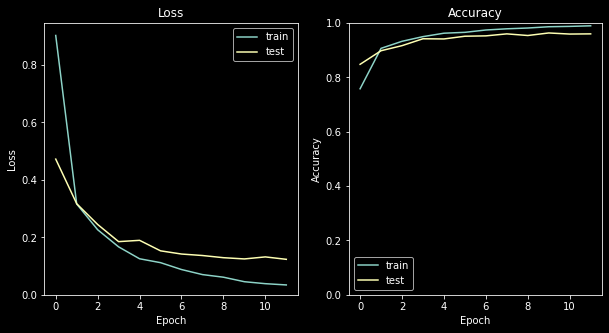

In [22]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    # plot history for F score etc.
    ax[1].plot(history.history['accuracy'])
    if validation:
        ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

# Predict unseen examples


In [46]:
num=36
import time
start = time.time()
y_pred = model.predict(X_test[:num], verbose=1, batch_size=12)
end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))

1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 17ms/step


Exec time per prediction = 0.005


Predictions are returned as vectors in one-hot encoding. Or rather, they are the activations of the last layer in the NN.

To convert them back to class numbers (0-9), we want to get the index of the output neuron with the highest activation using `argmax`.

In [47]:
Y_pred = np.argmax(y_pred, axis=1)


6


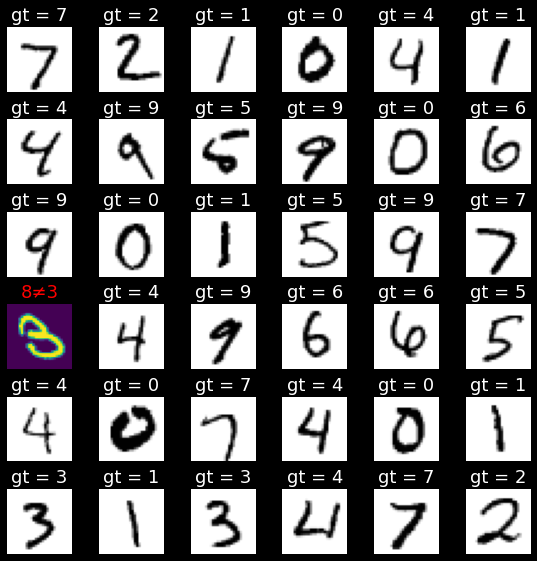

In [48]:
plot_images(X_test[:num], Y_pred, gt=y_test[:num])


# Take-Aways
- using convolutions in neural networks is mostly done with images (where the local neighborhood of a pixel contains meaning about objects ...)
  - convolutions are mostly used to generate multiple output feature maps
  - they are often paired with maxpooling layers to downsample inputs

- for classification, a CNN is concluded by dense layers (MLPs) that provide a class score 
- conv layers are more efficient than dense layers (less number of parameters)


- pathologies observed in this demonstration:
  - overfitting 
    - model has too many parameters and is capable of memorizing the training data
    - observed if training loss decreases (training accuracy increases), but test loss/accuracy stays constant
    - countermeasure: reduce the number of parameters of the network, regularize with drop-out layers
  - underfitting 
    - model has not enough parameters to learn anything
    - observed if training loss/accuracy exhibit random fluctuations around the test loss/accuracy
    - countermeasure: increase the number of parameters of the network

# Further Reading

- recap optimizers in the excellent blog post on [ruder.io](https://ruder.io/optimizing-gradient-descent/) and an intuition on their use
- stanford's [cs231n section on CNNs](https://cs231n.github.io/convolutional-networks/) and cs230 [cheatsheet for CNNs](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
- [a compilation of libraries and tools](https://github.com/ml-tooling/best-of-ml-python) that help you code up ML classifyers and predictors 
